In [1]:
from __future__ import division
import os, keras 

os.environ["KERAS_BACKEND"] = "theano"
import keras; import keras.backend
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation
from scipy.io import loadmat, savemat
import os.path
from keras import backend as K    
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import files

In [2]:
# Model training function
def train(In_train, Out_train, In_test, Out_test,
          epochs, batch_size,dr,
          num_hidden_layers, nodes_per_layer,
          loss_fn,n_BS,n_beams):
    
    in_shp = list(In_train.shape[1:])

    AP_models = []
    for idx in range(0, n_BS*n_beams-2, n_beams):
        idx_str = str(idx / n_beams + 1)
        model = models.Sequential()
        model.add(Dense(nodes_per_layer, activation='relu', input_shape=in_shp))
        model.add(Dropout(dr))
      
       
        for h in range(num_hidden_layers):
          model.add(Dense(nodes_per_layer, activation='relu',
                      kernel_initializer='normal'))
          model.add(Dropout(dr))
          model.add(Dense(n_beams, activation='relu', kernel_initializer='normal'))
          model.compile(loss=loss_fn, optimizer='adam',metrics=['acc'] )
          model.summary()
            
          # perform training ...
          earlyStoppingCallback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=0,mode='auto')
          filepath = "DLCB_code_output/Results_mmWave_ML" + str(idx)
          history = model.fit(In_train, Out_train[:, idx:idx + n_beams],batch_size=batch_size,epochs=epochs,verbose=2, validation_data=(In_test, Out_test[:,idx:idx + n_beams]),
                            callbacks = [keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                                keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                            ])
            # we re-load the best weights once training is finished
          model.load_weights(filepath)
            
          AP_models.append(model)
            
    return AP_models

In [3]:
pip install mat73

In [4]:

import mat73


In [ ]:

# Reading input and output sets generated from MATLAB
In_set_file=mat73.loadmat('/content/drive/MyDrive/DLCB_dataset/DLCB_input.mat')
Out_set_file=mat73.loadmat('/content/drive/MyDrive/DLCB_output.mat')

In_set=In_set_file['DL_input']
Out_set=Out_set_file['DL_output']

# Parameter initialization
num_user_tot=In_set.shape[0]
n_DL_size=[.001,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8]
count=0
num_tot_TX=4
n_beams=512

for DL_size_ratio in n_DL_size:
    
    print (DL_size_ratio)
    count=count+1
    DL_size=int(num_user_tot*DL_size_ratio)
    
    np.random.seed(2016)
    n_examples = DL_size
    num_train  = int(DL_size * 0.8)
    num_test   = int(num_user_tot*.2)
    
    train_index = np.random.choice(range(0,num_user_tot), size=num_train, replace=False)
    rem_index = set(range(0,num_user_tot))-set(train_index)
    test_index= list(set(np.random.choice(list(rem_index), size=num_test, replace=False)))
    
    In_train = In_set[train_index]
    In_test =  In_set[test_index] 
        
    Out_train = Out_set[train_index]
    Out_test = Out_set[test_index]
    
    
    # Learning model parameters
    nb_epoch = 10     
    batch_size = 100  
    dr = 0.05                  # dropout rate  
    num_hidden_layers=4
    nodes_per_layer=In_train.shape[1]
    loss_fn='mean_squared_error'
    
    # Model training
    AP_models = train(In_train, Out_train, In_test, Out_test,
                                          nb_epoch, batch_size,dr,
                                          num_hidden_layers, nodes_per_layer,
                                          loss_fn,num_tot_TX,n_beams)

    
    # Model running/testing
    DL_Result={}
    for id in range(0,num_tot_TX,1): 
        beams_predicted=AP_models[id].predict( In_test, batch_size=10, verbose=0)
    
        DL_Result['TX'+str(id+1)+'Pred_Beams']=beams_predicted
        DL_Result['TX'+str(id+1)+'Opt_Beams']=Out_test[:,id*n_beams:(id+1)*n_beams]

    DL_Result['user_index']=test_index
    savemat('DLCB_code_output/DL_Result'+str(count),DL_Result)
    

Streaming output truncated to the last 5000 lines.
Epoch 4/10
INFO:tensorflow:Assets written to: DLCB_code_output/Results_mmWave_ML1024/assets
197/197 - 5s - loss: 7.0129e-04 - acc: 0.5459 - val_loss: 7.8075e-04 - val_acc: 0.5155 - 5s/epoch - 25ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: DLCB_code_output/Results_mmWave_ML1024/assets
197/197 - 5s - loss: 6.6715e-04 - acc: 0.5576 - val_loss: 7.5976e-04 - val_acc: 0.5325 - 5s/epoch - 24ms/step
Epoch 6/10
INFO:tensorflow:Assets written to: DLCB_code_output/Results_mmWave_ML1024/assets
197/197 - 5s - loss: 6.4010e-04 - acc: 0.5693 - val_loss: 7.3876e-04 - val_acc: 0.5414 - 5s/epoch - 24ms/step
Epoch 7/10
197/197 - 3s - loss: 6.1512e-04 - acc: 0.5716 - val_loss: 7.3966e-04 - val_acc: 0.5347 - 3s/epoch - 17ms/step
Epoch 8/10
197/197 - 3s - loss: 5.8829e-04 - acc: 0.5866 - val_loss: 7.4123e-04 - val_acc: 0.5362 - 3s/epoch - 17ms/step
Epoch 9/10
INFO:tensorflow:Assets written to: DLCB_code_output/Results_mmWave_ML1024/assets
197/197 -

In [ ]:
# scatter plot of the circles dataset with points colored by class
from sklearn.datasets import make_circles
from numpy import where
from matplotlib import pyplot


In [ ]:
Out_train, Out_test = make_circles(n_samples=1000, noise=0.1, random_state=1)

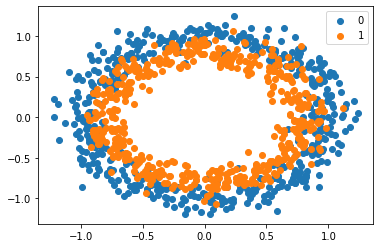

In [ ]:
for i in range(2):
	samples_ix = where(Out_test == i)
	pyplot.scatter(Out_train[samples_ix, 0], Out_train[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import scipy.io
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from io import StringIO
from pylab import scatter, show, title, xlabel, ylabel, plot, contour

In [ ]:
from keras.utils.vis_utils import plot_model
#visualise a model
plot_model(AP_models, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

AttributeError: ignored